In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)


In [14]:
# 1. Load dataset COVID Jabar
csv_path = "covid_jabar_perkembangan_harian.csv"  # pastikan file ada di folder kerja
df = pd.read_csv(csv_path)

print("Kolom dataset asli:")
print(df.columns)
df.head()


Kolom dataset asli:
Index(['tanggal', 'kode_kab_kota', 'nama_kab_kota', 'konfirmasi_total', 'konfirmasi_sembuh', 'konfirmasi_meninggal',
       'konfirmasi_aktif', 'konfirmasi_total_daily_growth', 'konfirmasi_sembuh_daily_growth',
       'konfirmasi_meninggal_daily_growth', 'konfirmasi_aktif_daily_growth', 'kota_kab_belum_teridentifikasi',
       'sembuh_unidentified', 'meninggal_unidentified', 'id'],
      dtype='object')


,tanggal,kode_kab_kota,nama_kab_kota,konfirmasi_total,konfirmasi_sembuh,konfirmasi_meninggal,konfirmasi_aktif,konfirmasi_total_daily_growth,konfirmasi_sembuh_daily_growth,konfirmasi_meninggal_daily_growth,konfirmasi_aktif_daily_growth,kota_kab_belum_teridentifikasi,sembuh_unidentified,meninggal_unidentified,id
0,2020-03-01 00:00:00,32,jawa barat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1
1,2020-03-01 00:00:00,3204,Kabupaten Bandung,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,2
2,2020-03-01 00:00:00,3217,Kabupaten Bandung Barat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,3
3,2020-03-01 00:00:00,3216,Kabupaten Bekasi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,4
4,2020-03-01 00:00:00,3201,Kabupaten Bogor,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,5


In [15]:
# 2. Agregasi: total konfirmasi_aktif per tanggal (semua kab/kota dijumlahkan)

df["tanggal"] = pd.to_datetime(df["tanggal"])

df_group = (
    df.groupby("tanggal", as_index=False)["konfirmasi_aktif"]
      .sum()
      .sort_values("tanggal")
      .reset_index(drop=True)
)

print("Cuplikan data agregat (total kasus aktif per tanggal):")
df_group.head()


Cuplikan data agregat (total kasus aktif per tanggal):


,tanggal,konfirmasi_aktif
0,2020-03-01,2.0
1,2020-03-02,2.0
2,2020-03-03,1.0
3,2020-03-04,3.0
4,2020-03-05,3.0


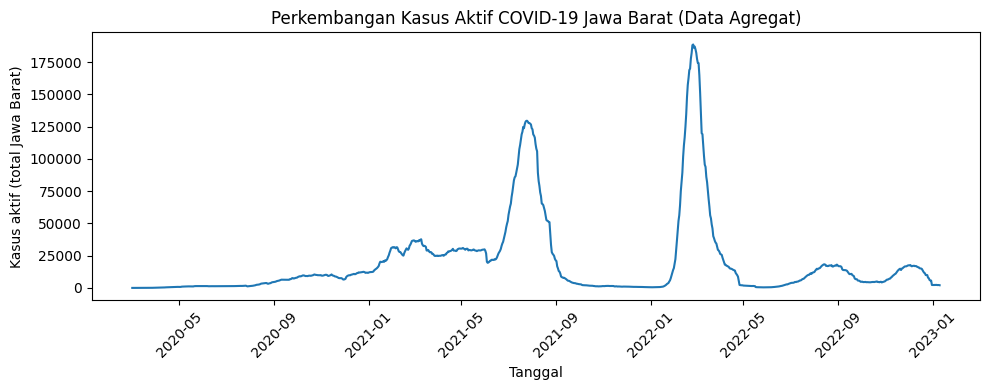

In [16]:
# 3. Visualisasi awal data total kasus aktif per hari

plt.figure(figsize=(10, 4))
plt.plot(df_group["tanggal"], df_group["konfirmasi_aktif"])
plt.xlabel("Tanggal")
plt.ylabel("Kasus aktif (total Jawa Barat)")
plt.title("Perkembangan Kasus Aktif COVID-19 Jawa Barat (Data Agregat)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [17]:
# 4. Memilih deret waktu yang akan dipakai

df_used = df_group[df_group["konfirmasi_aktif"].notna()].copy()
df_used = df_used.reset_index(drop=True)

print("Jumlah hari data yang tersedia:", len(df_used))
df_used.head()


Jumlah hari data yang tersedia: 1046


,tanggal,konfirmasi_aktif
0,2020-03-01,2.0
1,2020-03-02,2.0
2,2020-03-03,1.0
3,2020-03-04,3.0
4,2020-03-05,3.0


In [19]:
# 5. Tetapkan populasi total dan nilai awal S(0), I(0)

# Perkiraan populasi Jawa Barat
N = 50_000_000  # ~ 50 juta jiwa

# Deret kasus aktif (dalam orang)
I_data = df_used["konfirmasi_aktif"].values.astype(float)
tanggal = df_used["tanggal"].values

# Nilai awal kasus aktif (hari pertama)
I0_count = I_data[0]

# Konversi ke proporsi i(0) = I0 / N
i0 = I0_count / N

# Asumsi awal: hampir semua penduduk masih rentan (R(0) ~ 0)
s0 = 1.0 - i0

print("Populasi total (N):", N)
print("Kasus aktif awal (I0):", I0_count)
print("Proporsi awal rentan s0:", s0)
print("Proporsi awal terinfeksi i0:", i0)


Populasi total (N): 50000000
Kasus aktif awal (I0): 2.0
Proporsi awal rentan s0: 0.99999996
Proporsi awal terinfeksi i0: 4e-08


In [20]:
# 6. Estimasi parameter dari data

# Ambil hanya titik dengan I > 0 untuk menghindari log(0)
mask_pos = I_data > 0
I_pos = I_data[mask_pos]

if len(I_pos) < 2:
    raise ValueError("Data positif terlalu sedikit untuk estimasi r.")

# Estimasi r dari rata-rata log growth: ln(I_{n+1} / I_n)
growth_logs = np.log(I_pos[1:] / I_pos[:-1])
r_est = growth_logs.mean()

# Asumsi awal gamma (laju kesembuhan) -> lama sakit rata-rata ~ 1/gamma
gamma_est = 0.1  # misal rata-rata 10 hari

# Dari hubungan model SIR: r ≈ beta * S0 - gamma  =>  beta ≈ (r + gamma) / S0
beta_est = (r_est + gamma_est) / s0 if s0 > 0 else 0.2

print("Estimasi r dari data:", r_est)
print("Asumsi awal gamma:", gamma_est)
print("Estimasi awal beta:", beta_est)


Estimasi r dari data: 0.006645059529406244
Asumsi awal gamma: 0.1
Estimasi awal beta: 0.1066450637952088


In [21]:
# 7. Definisi model SIR dan fungsi Metode Euler (2 variabel: S dan I dalam proporsi)

def f_sir(t, y, params):
    """
    Model SIR sederhana dalam proporsi:

        dS/dt = -beta * S * I
        dI/dt =  beta * S * I - gamma * I

    y = [S, I]
    params = {"beta": ..., "gamma": ...}
    """
    S, I = y
    beta = params["beta"]
    gamma = params["gamma"]

    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    return np.array([dSdt, dIdt])


def euler_solve(f, t0, y0, h, n_steps, params):
    """
    Metode Euler untuk sistem 2 variabel.

    f       : fungsi ODE f(t, y, params) -> array [dSdt, dIdt]
    t0      : waktu awal
    y0      : array awal [S0, I0]
    h       : step size (hari per langkah)
    n_steps : jumlah langkah Euler
    params  : dict parameter (beta, gamma)
    """
    t_values = np.zeros(n_steps + 1)
    y_values = np.zeros((n_steps + 1, len(y0)))

    t_values[0] = t0
    y_values[0, :] = y0

    for n in range(n_steps):
        y_values[n+1, :] = y_values[n, :] + h * f(t_values[n], y_values[n, :], params)
        t_values[n+1] = t_values[n] + h

    return t_values, y_values


In [22]:
# 8. Menjalankan simulasi SIR dengan Metode Euler

h = 1.0  # 1 hari per langkah
n_days = len(df_used)
n_steps = n_days - 1  # karena titik awal sudah terhitung

t0 = 0.0
y0 = np.array([s0, i0])

params = {"beta": beta_est, "gamma": gamma_est}

t_sim, y_sim = euler_solve(f_sir, t0, y0, h, n_steps, params)

S_sim = y_sim[:, 0]              # proporsi S(t)
I_sim_prop = y_sim[:, 1]         # proporsi I(t)
I_sim_count = I_sim_prop * N     # ubah ke jumlah orang

print("Panjang simulasi:", len(I_sim_count))
print("Panjang data    :", len(I_data))


Panjang simulasi: 1046
Panjang data    : 1046


In [23]:
# 9. Gabungkan data asli dan hasil simulasi ke satu DataFrame

I_data_used = I_data[: len(I_sim_count)]
tanggal_used = tanggal[: len(I_sim_count)]

df_result = pd.DataFrame({
    "tanggal": tanggal_used,
    "I_data": I_data_used,
    "I_SIR_Euler": I_sim_count
})

df_result.head()


,tanggal,I_data,I_SIR_Euler
0,2020-03-01,2.0,2.000000
1,2020-03-02,2.0,2.013290
2,2020-03-03,1.0,2.026669
3,2020-03-04,3.0,2.040136
4,2020-03-05,3.0,2.053693


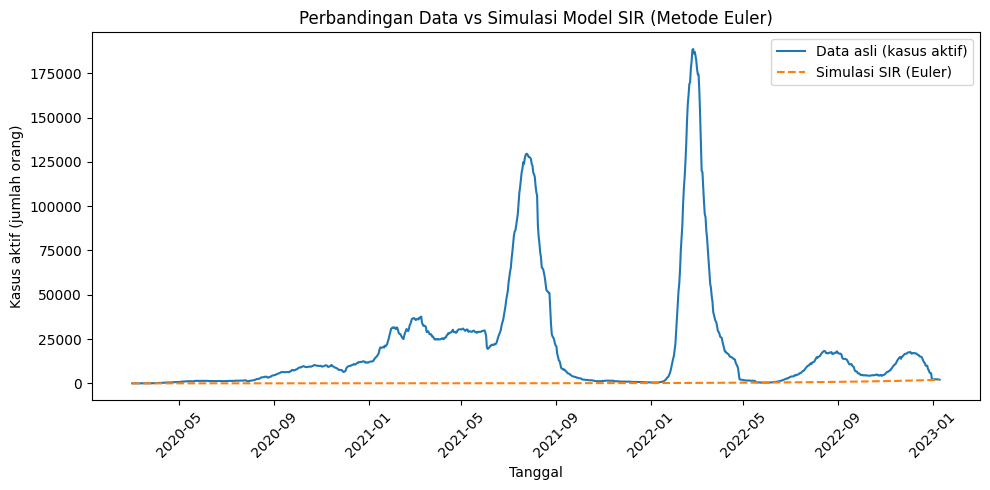

In [24]:
# 10. Plot data vs hasil simulasi SIR (Euler)

plt.figure(figsize=(10, 5))
plt.plot(df_result["tanggal"], df_result["I_data"], label="Data asli (kasus aktif)")
plt.plot(df_result["tanggal"], df_result["I_SIR_Euler"], "--", label="Simulasi SIR (Euler)")
plt.xlabel("Tanggal")
plt.ylabel("Kasus aktif (jumlah orang)")
plt.title("Perbandingan Data vs Simulasi Model SIR (Metode Euler)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [25]:
# 11. Menghitung error antara data dan simulasi (MSE dan MAE)

diff = df_result["I_SIR_Euler"].values - df_result["I_data"].values
mse = np.mean(diff**2)
mae = np.mean(np.abs(diff))

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)


Mean Squared Error (MSE): 1424219540.6639585
Mean Absolute Error (MAE): 19269.646364339897
